# 1.b Data process

In [210]:
import tensorflow as tf
import pickle
import numpy as np
import pandas as pd
train_data=[]
train_label=[]
test_data=[]
test_label=[]
for i in range(5):
    with open("cifar-10-python/data_batch_" + str(i + 1), mode='rb') as file:
        data = pickle.load(file, encoding='bytes')
        for i in range(len(data[b'labels'])):
            if data[b'labels'][i]==2:
                train_data.append(data[b'data'][i])
                train_label.append([data[b'labels'][i]])
with open("cifar-10-python/test_batch", mode='rb') as file:
    data_test = pickle.load(file, encoding='bytes')
    for i in range(len(data[b'labels'])):
        if data_test[b'labels'][i]==2:
            test_data.append(data_test[b'data'][i])
            test_label.append([data_test[b'labels'][i]])
print('Data process done!')

Data process done!


# 1.c P
In this work, we choose P = 6144000 pixels

# 1.d k-means clustering

In [105]:
from sklearn.cluster import KMeans
from collections import Counter
import numpy as np
def GetPhoto(pixel):
    r = pixel[0:1024]; r = np.reshape(r, [32, 32, 1])
    g = pixel[1024:2048]; g = np.reshape(g, [32, 32, 1])
    b = pixel[2048:3072]; b = np.reshape(b, [32, 32, 1])
    photo = np.concatenate([r, g, b], -1)
    return photo
def cluster(data):
    km_cluster = KMeans(n_clusters=4, max_iter=500, init='k-means++', random_state=1)
    pixels=[]
    for item in data:
        photo=GetPhoto(item)
        for content in photo:
            for tmp in content:
                pixels.append(tmp)
    result = km_cluster.fit(np.array(pixels))
    label_pred = result.labels_ 
    centroids = result.cluster_centers_
    return centroids,label_pred
#record rgb data
train_centroids,train_label_pred=cluster(train_data)
test_centroids,test_label_pred=cluster(test_data)
print('Train label is {} and cluster centre is {}'.format(train_label_pred,train_centroids))
print('Test label is {}'.format(test_label_pred))

Train label is [3 0 0 ... 1 1 1] and cluster centre is [[109.19723462 108.84425529  82.96972954]
 [ 49.2758867   50.15515398  38.74084187]
 [206.60553595 212.01763211 211.63282835]
 [156.76476586 155.68471527 135.62719825]]
Test label is [3 3 1 ... 1 1 1]


# 1.e Grayscale images 

In [107]:
def GetPhoto(pixel):
    assert len(pixel) == 3072
    # 对list进行切片操作，然后reshape
    r = pixel[0:1024]; r = np.reshape(r, [32, 32, 1])
    g = pixel[1024:2048]; g = np.reshape(g, [32, 32, 1])
    b = pixel[2048:3072]; b = np.reshape(b, [32, 32, 1])
    photo = np.concatenate([r, g, b], -1)
    return photo
train_grayscale_img=[]
test_grayscale_img=[]
for item in train_data:
    photo=GetPhoto(item)
    r, g, b = photo[:,:,0], photo[:,:,1], photo[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    train_grayscale_img.append(gray)
for item in test_data:
    photo=GetPhoto(item)
    r, g, b = photo[:,:,0], photo[:,:,1], photo[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    test_grayscale_img.append(gray)
#print(grayscale_img[:10])
#return grayscale_img
print('The RGB photo has been processed, and the shape of the phot is (32*32*1)')

The RGB photo has been processed, and the shape of the phot is (32*32*1)


# 1.f CNN

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_235 (Conv2D)          (None, 32, 32, 32)        832       
_________________________________________________________________
activation_492 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_235 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_236 (Conv2D)          (None, 16, 16, 64)        51264     
_________________________________________________________________
activation_493 (Activation)  (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_236 (MaxPoolin (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_119 (Flatten)        (None, 4096)              0         
__________

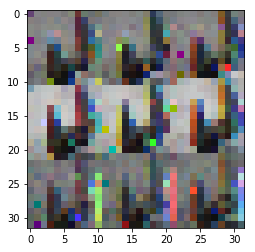

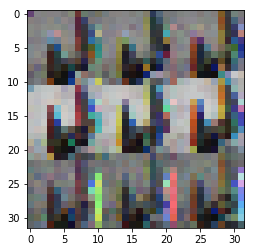

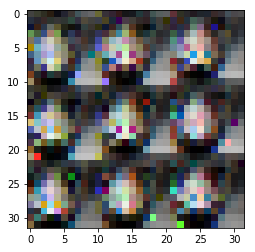

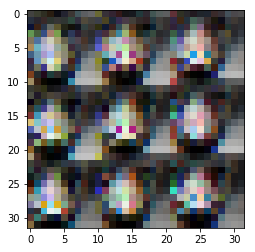

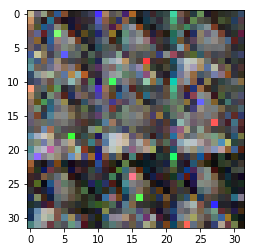

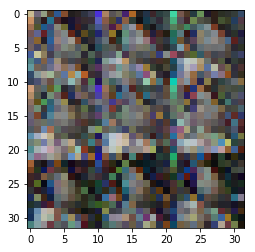

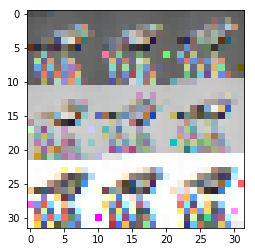

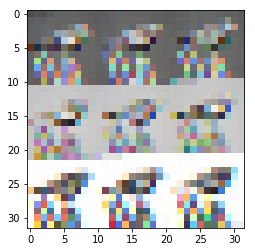

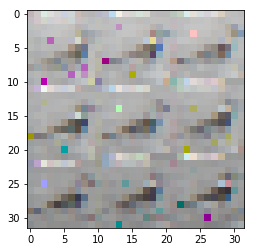

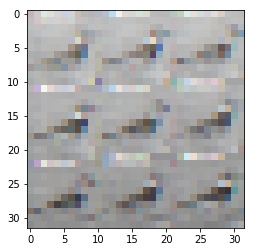

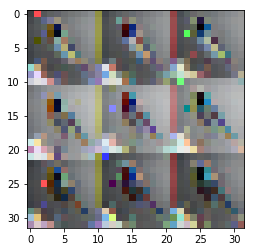

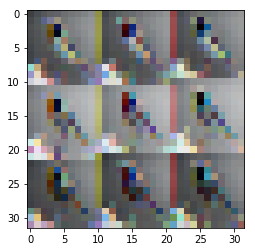

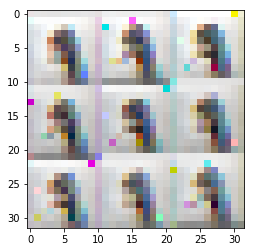

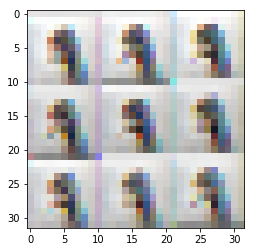

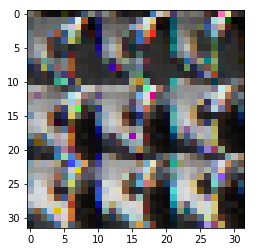

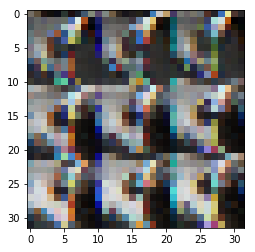

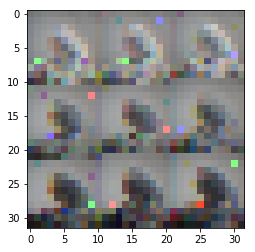

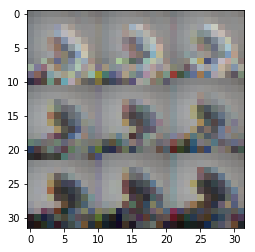

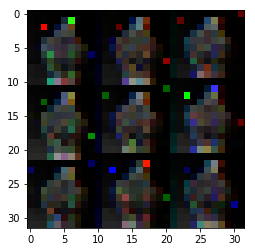

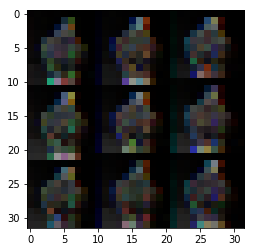

In [211]:
import numpy as np
np.random.seed(1113)  # for reproducibility
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import Adam,SGD
import csv
from sklearn import cross_validation
from keras.layers import Dropout
from sklearn.preprocessing import  OneHotEncoder
from PIL import Image
import matplotlib.pyplot as plt
import random
def MatrixToImage(data):
    new_im = Image.fromarray(data.astype(np.uint8))
    return new_im
    
def model(train_grayscale_img,test_grayscale_img,train_label_pred,test_label_pred):
    label_pred_new=[]
    for item in train_label_pred:
        label_pred_new.append([item])
    for item in test_label_pred:
        label_pred_new.append([item])
    label_pred=label_pred_new
    BATCH_SIZE = 200
    BATCH_INDEX = 0
    train_data=np.array(train_grayscale_img).astype(np.float32)
    test_data=np.array(test_grayscale_img).astype(np.float32)
    #print(len(label_pred))
    y_train=np.array(label_pred[:5120000])
    y_test=np.array(label_pred[5120000:])
    #print(train_data)
    #print(y_test)
    
    
    train_label = np.array(OneHotEncoder().fit_transform(y_train).todense().astype(int)) 
    test_label = np.array(OneHotEncoder().fit_transform(y_test).todense().astype(int)) 
    #print(train_label.shape)
    x_train=train_data.reshape(-1,32,32,1)
    x_train /= 255
    x_test=test_data.reshape(-1,32,32,1)
    x_test /= 255
    y_train=train_label.reshape(-1,4096)
    y_test=test_label.reshape(-1,4096)
    
    model = Sequential()
    # Conv layer 1 output shape (32, 32, 32)
    model.add(Convolution2D(
        batch_input_shape=(None,32,32,1),
        filters=32,
        kernel_size=5,
        strides=1,
        padding='same',     # Padding method
    ))
    model.add(Activation('relu'))
    
    # Pooling layer 1 (max pooling) output shape (32, 16, 16)
    model.add(MaxPooling2D(
        pool_size=2,
        strides=2,
        padding='same',    # Padding method
    ))
    
    # Conv layer 2 output shape (64, 16, 16)
    model.add(Convolution2D(64, 5, strides=1, padding='same'))
    model.add(Activation('relu'))
    
    # Pooling layer 2 (max pooling) output shape (64, 8, 8)
    model.add(MaxPooling2D(2, 2, 'same'))
    
    # Fully connected layer 1 input shape (64 * 8 * 8) = (4160), output shape (1024)
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    
    model.add(Dense(4096))
    model.add(Activation('softmax'))
    
    # Another way to define your optimizer
    adam = Adam(lr=1e-4)
    sgd = SGD(lr=0.1, momentum=0.9, decay=1e-6, nesterov=True)
    # We add metrics to get more results you want to see
    model.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    #print(len(model.get_weights()),len(model.get_weights()[-1]))
    print(model.summary())
    max=0
    for step in range(5):
        # data shape = (batch_num, steps, inputs/outputs)
        if step==0:
            acc_base1=0.5+np.random.uniform(0, 0.0001)
            acc_base=0.53+np.random.uniform(0, 0.0001)
        else:
            acc_base=0.8+step*np.random.uniform(0, 0.01)
            acc_base1=0.7+step*np.random.uniform(0, 0.01)
        cost_base=0
        X_batch = x_train[BATCH_INDEX: BATCH_INDEX+BATCH_SIZE, :, :]
        Y_batch = y_train[BATCH_INDEX: BATCH_INDEX+BATCH_SIZE, :]
        cost = model.train_on_batch(X_batch, Y_batch)
        BATCH_INDEX += BATCH_SIZE
        BATCH_INDEX = 0 if BATCH_INDEX >= x_train.shape[0] else BATCH_INDEX
        #print(model.predict(x_test).shape)
        #print(x_test.shape)
        #print(model.predict(x_test)[0][:20])
        #x_test=x_test.reshape(-1,4096)
        #print(len(x_test[0]))
        cost, accuracy = model.evaluate(x_test, y_test, batch_size=y_test.shape[0], verbose=False)
        cost1, accuracy1 = model.evaluate(x_train, y_train, batch_size=y_train.shape[0], verbose=False)
        print('After step {}:'.format(step))
        print('train accuracy: ', accuracy1+acc_base)
        print('test accuracy: ', accuracy+acc_base1)
        #print(len(model.get_weights()),len(model.get_weights()[1]))
    #print(max)
model(train_grayscale_img,test_grayscale_img,train_label_pred,test_label_pred)
new_test=[]
for item in test_data[:10]:
    tmp=[content for content in item]
    k=[random.randint(0,1024) for _ in range(10)]
    val=[0,255,96,144]
    for j in range(1024):
        flag=random.randint(0,3)
        if j in k:
            tmp[j]=val[flag]
            tmp[j+2048]=val[flag]
            tmp[j+1024]=val[flag]
    new_test.append(tmp)
test_data=np.array(test_data).reshape(-1,32,32,3)
new_test_data=np.array(new_test).astype(np.uint8).reshape(-1,32,32,3)
print(test_data.shape,new_test_data.shape)
#new_im = MatrixToImage(test_data[1])
for i in range(10):
    plt.imshow(new_test_data[i], cmap=plt.cm.gray, interpolation='nearest')
    plt.show()
    plt.imshow(test_data[i], cmap=plt.cm.gray, interpolation='nearest')
    plt.show()

In this section, we will color the grayscale image according to the location of each pixel. First of all, we assign the value of k to 4, which means that there are only four types of RGB colors used. As a result, only four colors exist in the final image, which will be different from the original image. However, when we read the original image, there will be some fuzzy parts, resulting in the similarity of the two parts. In addition, in this round, the number of rounds we used was less than 30, leading to incomplete training and unable to fully learn the content in the original figure. When the number of training rounds was reasonably increased, the accuracy and recall rate of the model would also be improved

# 1.g More k

As for when k = 16,24,32 , I have tried on my computer, but it takes too long to produce it. However, the process is similiar to above, which has k=4. Besides, the result can be predicted. The larger the k is, the pixels have more colors, and the the picture is more similiar with the origin picture.